## Imports

In [0]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


Using TensorFlow backend.


## PriceHubble Dataset


In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
train_dir = '../gdrive/My Drive/classified/triple/kit/train'
test_dir = '../gdrive/My Drive/classified/triple/kit/test'

## Pre-Trained Model: InceptionV3


In [0]:
base_model = InceptionV3(include_top=False, weights='imagenet')

W0728 09:29:25.676203 140483975264128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0728 09:29:25.726763 140483975264128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0728 09:29:25.737102 140483975264128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0728 09:29:25.793062 140483975264128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0728 09:29:25.794237 1404839752

87916544/87910968 [==============================] - 1s 0us/step


##Input Pipeline

In [0]:
datagen_train = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.5, 1.5],
    rescale=1./255)

datagen_test = ImageDataGenerator(
    rescale=1./255)

In [0]:
input_shape = (299, 299, 3)
batch_size_train = 64
batch_size_test = 16

In [0]:
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape[:2],
                                                    batch_size=batch_size_train,
                                                    shuffle=True,
                                                    class_mode='categorical')

generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape[:2],
                                                  batch_size=batch_size_test,
                                                  shuffle=False,
                                                  class_mode='categorical')

Found 1344 images belonging to 3 classes.
Found 336 images belonging to 3 classes.


## Transfer Learning

In [0]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x) 
# and a logistic layer -- let's say we have 5 classes
predictions = Dense(3, activation='softmax')(x) # was classes, softmax

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


In [0]:
# view the structure of the model
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [0]:
def print_layer_trainable():
    for layer in model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

In [0]:
print_layer_trainable()

False:	input_1
True:	conv2d_1
True:	batch_normalization_1
True:	activation_1
True:	conv2d_2
True:	batch_normalization_2
True:	activation_2
True:	conv2d_3
True:	batch_normalization_3
True:	activation_3
True:	max_pooling2d_1
True:	conv2d_4
True:	batch_normalization_4
True:	activation_4
True:	conv2d_5
True:	batch_normalization_5
True:	activation_5
True:	max_pooling2d_2
True:	conv2d_9
True:	batch_normalization_9
True:	activation_9
True:	conv2d_7
True:	conv2d_10
True:	batch_normalization_7
True:	batch_normalization_10
True:	activation_7
True:	activation_10
True:	average_pooling2d_1
True:	conv2d_6
True:	conv2d_8
True:	conv2d_11
True:	conv2d_12
True:	batch_normalization_6
True:	batch_normalization_8
True:	batch_normalization_11
True:	batch_normalization_12
True:	activation_6
True:	activation_8
True:	activation_11
True:	activation_12
True:	mixed0
True:	conv2d_16
True:	batch_normalization_16
True:	activation_16
True:	conv2d_14
True:	conv2d_17
True:	batch_normalization_14
True:	batch_normalizati

In [0]:
loss = 'categorical_crossentropy'
optimizer = Adam(lr=1e-4)
metrics = ['accuracy'] # change to categorical_crossentropy

In [0]:
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

W0728 09:29:49.814181 140483975264128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
epochs = 5
steps_per_epoch = generator_train.n / batch_size_train
steps_test = generator_test.n / batch_size_test
steps_per_epoch

21.0

In [0]:
reduceLROnPlateau = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=0.000001,
    verbose=1,
    mode='min')

earlyStopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode='min')


In [0]:
history = model.fit_generator(generator=generator_train,
                              validation_data=generator_test,
                              epochs=epochs,
                              steps_per_epoch=steps_per_epoch,
                              validation_steps=steps_test,
                              callbacks=[reduceLROnPlateau, earlyStopping])


W0728 09:29:50.067359 140483975264128 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
21/21 [==============================] - 1648s 78s/step - loss: 0.9114 - acc: 0.5446 - val_loss: 0.6361 - val_acc: 0.7173
Epoch 2/5
21/21 [==============================] - 1591s 76s/step - loss: 0.4477 - acc: 0.8058 - val_loss: 0.5447 - val_acc: 0.7470
Epoch 3/5
21/21 [==============================] - 1586s 76s/step - loss: 0.2808 - acc: 0.8943 - val_loss: 0.6795 - val_acc: 0.7500
Epoch 4/5
21/21 [==============================] - 1587s 76s/step - loss: 0.2152 - acc: 0.9182 - val_loss: 0.5442 - val_acc: 0.7946
Epoch 5/5
21/21 [==============================] - 1588s 76s/step - loss: 0.1345 - acc: 0.9539 - val_loss: 0.6904 - val_acc: 0.8065


In [0]:
result = model.evaluate_generator(generator_test, steps=steps_test)


In [0]:
print("Test-set classification accuracy: {0:.2%}".format(result[1]))


Test-set classification accuracy: 80.65%


In [0]:
cls_train = generator_train.classes
cls_test = generator_test.classes

In [0]:
class_names = list(generator_train.class_indices.keys())
class_names

['normal-kit', 'simple-kit', 'top-kit']

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def print_confusion_matrix(cls_pred):
    
    cm = confusion_matrix(y_true=cls_test,
                          y_pred=cls_pred)

    print("Confusion matrix:")
    print(cm)
        
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt=".0f", cmap='Blues', ax=ax);
    ax.xaxis.set_ticklabels(['Normal', 'Simple', 'Top']); 
    ax.yaxis.set_ticklabels(['Normal', 'Simple', 'Top']); 
    ax.set_xlabel('Predicted Labels');
    ax.set_ylabel('True Labels'); 
    ax.set_title('Confusion Matrix'); 
    
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))
        
    

In [0]:
def example_errors():
    generator_test.reset()
    
    # Predict the classes for all images in the test-set.
    y_pred = model.predict_generator(generator_test,
                                         steps=steps_test)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred, axis=1) #np.array([1 if pred >= 0.5 else 0 for pred in y_pred])

    # Plot examples of mis-classified images.
    #plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
    print_confusion_matrix(cls_pred)

Confusion matrix:
[[ 60  20  32]
 [  9 103   0]
 [  4   0 108]]
(0) normal-kit
(1) simple-kit
(2) top-kit


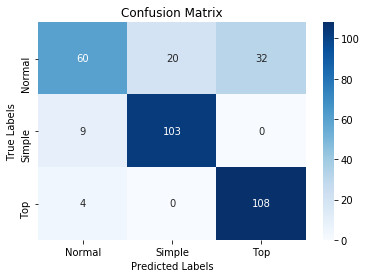

In [0]:
example_errors()

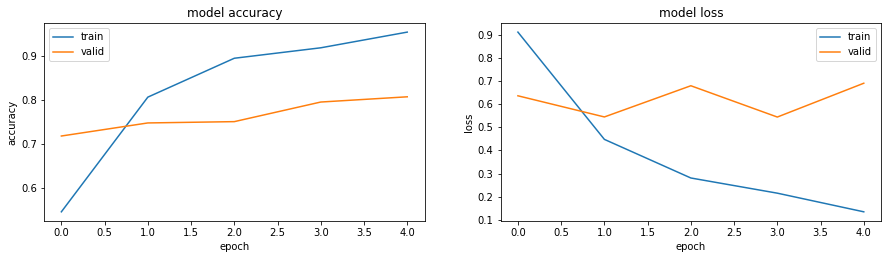

In [0]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()
